In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [2]:
# Function to create a list of image file paths
def create_images_list(path):
    full_path = []
    images = sorted(os.listdir(path))
    for i in images:
        full_path.append(os.path.join(path, i))
    return full_path

# Load images only if the corresponding mask is present and vice versa
def images_from_masks(base_path, images_path):
    full_path = []
    images = sorted(os.listdir(images_path))
    base_path = base_path + '/CXR_png'  # Assuming this is where the actual images are stored
    for i in images:
        if i[0] == 'C':
            img_path = os.path.join(base_path, i[:-9] + '.png')
        elif i[0] == 'M':
            img_path = os.path.join(base_path, i[:-4] + '.png')
        
        # Check if the image exists; if not, skip
        if os.path.exists(img_path):
            full_path.append(img_path)
    return full_path

In [3]:
# Function to load images and masks, filtering out missing ones
def load_data(images_folder, masks_folder):
    images = []
    masks = []
    
    image_files = sorted(os.listdir(images_folder))
    mask_files = sorted(os.listdir(masks_folder))
    
    for image_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(images_folder, image_file)
        mask_path = os.path.join(masks_folder, mask_file)
        
        # Check if both image and mask exist
        if os.path.exists(img_path) and os.path.exists(mask_path):
            # Load and preprocess image
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (256, 256))
            image = np.expand_dims(image, axis=-1)
            images.append(image)

            # Load and preprocess mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, (256, 256))
            mask = np.expand_dims(mask, axis=-1)
            masks.append(mask)

    return np.array(images), np.array(masks)


In [4]:
# Paths to your image and mask folders
images_folder = 'CXR_png/images'
masks_folder = 'CXR_png/masks'

# Load the data, filtering missing images and masks
images, masks = load_data(images_folder, masks_folder)

# Convert grayscale images to RGB by repeating the single channel
images = np.repeat(images, 3, axis=-1)

# Normalize images and masks
images = images.astype('float32') / 255.0
masks = masks.astype('float32') / 255.0

In [5]:
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [6]:


def dice_coefficient(y_true, y_pred, smooth=1e-6):
    # Use TensorFlow functions to flatten the tensors
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [7]:
# Build SegNet model with VGG16 backbone
def build_segnet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)
    for layer in vgg16.layers:
        layer.trainable = False  # Freeze VGG16 layers

    # Extract features from VGG16
    skip1 = vgg16.get_layer('block1_conv2').output
    skip2 = vgg16.get_layer('block2_conv2').output
    skip3 = vgg16.get_layer('block3_conv3').output
    skip4 = vgg16.get_layer('block4_conv3').output
    bottleneck = vgg16.get_layer('block5_conv3').output

    # Decoder
    x = UpSampling2D((2, 2))(bottleneck)
    x = concatenate([x, skip4])
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip3])
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip2])
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)
    x = concatenate([x, skip1])
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x)

    model = Model(inputs, outputs)
    return model

In [8]:
# Define input shape and build the model
input_shape = (256, 256, 3)
model = build_segnet(input_shape)

# Compile the model with binary crossentropy loss and Dice coefficient metric
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[dice_coefficient])

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 24,891,137 (94.95 MB)

 Trainable params: 10,176,449 (38.82 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=16, callbacks=[early_stopping])


Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1979s 55s/step - dice_coefficient: 0.3146 - loss: 2.7315 - val_dice_coefficient: 0.6044 - val_loss: 0.3153
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1286s 36s/step - dice_coefficient: 0.6328 - loss: 0.3025 - val_dice_coefficient: 0.6451 - val_loss: 0.2891
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1384s 38s/step - dice_coefficient: 0.6635 - loss: 0.2734 - val_dice_coefficient: 0.6393 - val_loss: 0.3143
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1547s 43s/step - dice_coefficient: 0.6462 - loss: 0.2833 - val_dice_coefficient: 0.6849 - val_loss: 0.2786
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 1966s 55s/step - dice_coefficient: 0.6846 - loss: 0.2592 - val_dice_coefficient: 0.6359 - val_loss: 0.2751


In [10]:
def evaluate_model(model, X_val, y_val):
    predictions = model.predict(X_val)
    predictions = (predictions > 0.5).astype(np.float32)

    dice_scores = []
    for i in range(predictions.shape[0]):
        dice = dice_coefficient(y_val[i], predictions[i])
        dice_scores.append(dice)
    
    return np.mean(dice_scores)

average_dice = evaluate_model(model, X_val, y_val)
print(f"Average Dice Coefficient: {average_dice:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 216s 42s/step
Average Dice Coefficient: 0.7253


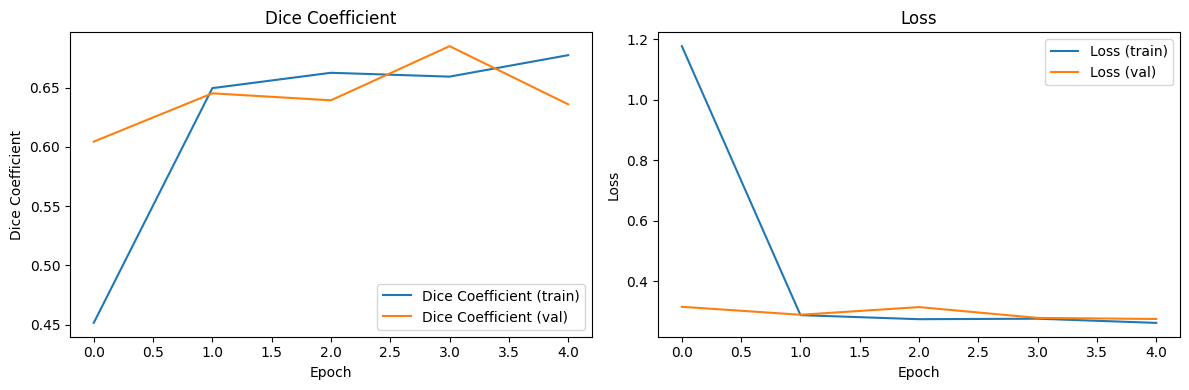

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Dice Coefficient (train)')
plt.plot(history.history['val_dice_coefficient'], label='Dice Coefficient (val)')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Loss (val)')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
